In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)

def sech(x):
    return 2/(np.exp(x)+np.exp(-x))

def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def f(x, a, h):
    return a - h*x + np.pi/2


def p2std(p):
    return 10000*np.exp(-p)

#p2std(9)

# Generative Process
$$
  \dot{\vec{x}}(t) = f(\vec{x}(t), \alpha) =
      \left[\begin{array}{ccc} 0 & 1 & 0 \\ -\omega^2 & 0 & 0 \\ \alpha &0 &-1 \end{array}\right] \cdot \vec{x}(t) =
      \left[\begin{array}{c} x_1(t) \\ -\omega^2 x_0(t) \\ \alpha x_0(t) - x_2(t) \end{array}\right] \nonumber
$$
## Initial conditions
$$
\vec{x}(0) = \left[ \begin{array}{c} x_0(0) \\ x_1(0) \\ x_2(0) \end{array} \right] = \left[ \begin{array}{c} 1 \\ 0 \\ \frac{ \alpha }{ \omega^2 +1 } \end{array} \right]
$$
## Solution
$$
\vec{x}(t) =
  \left[ \begin{array}{c} x_0(t) \\ x_1(t) \\ x_2(t) \end{array} \right] =
  \left[ \begin{array}{c} \cos(\omega t) \\ - \omega \sin(\omega t) \\ \frac{ \alpha ( \cos (\omega t) + \omega \sin (\omega t) ) }{ \omega^2 + 1 } \end{array} \right]
$$

From $x_2$ is extracted the proprioceptive sensory input
$$
s_0 (t) = x_2(t) + \mathcal{N}(s_0;0,\Sigma_{s_0}^{GP})
$$


In [2]:
class GP:                                                               # Generative Process Class

    def __init__(self, dt, omega2_GP=0.5, alpha=1):

        self.omega2 = omega2_GP                                         # Harmonic oscillator angular frequency (both x_0 and x_2)
        self.a = alpha                                                  # Harmonic oscillator amplitude (no really)
        self.x = np.array([1.,0., self.a/(self.omega2 + 1)])            # Vector x={x_0, x_1, x_2} initialized with his initial conditions
        self.s = np.array([self.a/(self.omega2 + 1), 0.])               # Array storing respectively proprioceptive sensory input (initialized with the real
                                                                        # value x_2) and touch sensory input
        self.Sigma_s = 0.01                                             # Variance of the Gaussian noise that gives proprioceptive sensory input
        self.dt = dt                                                    # Size of a simulation step
        self.t = 0                                                      # Time variable
        self.platform_position = 0.5                                    # Platform position (when is present) with respect to x_2 variable
        self.platform_interval = [15, 75]                               # Time interval in which the platform appears


    def update(self, action):                                           # Function that implement dynamics of the process.
                                                                        # Action argument (double) is the variable that comes from the GM that modifies alpha
                                                                        # variable affecting the amplitude of the oscillation.

        self.t += dt                                                    # Increment of time variable
        self.a += action                                        # Increment of alpha variable (that changes the amplitude) given by agent's action
        self.x[0] += self.dt*(self.x[1])                                # GP dynamics implementation
        self.x[1] += self.dt*(-self.omega2*self.x[0])
        self.x[2] += self.dt*(self.a*self.x[0] - self.x[2])
        if self.t>self.platform_interval[0] and self.t<self.platform_interval[1]:                            # Platform Action
            if self.x[2] > self.platform_position:
                self.s[1] = 1.
                self.x[2] = self.platform_position
            else:
                self.s[1] = 0.
        else:
            self.s[1] = 0.
        self.s[0] = self.x[2] + self.Sigma_s*rng.randn()

    def platform_for_graph(self):
        plat = []
        for t in np.arange(0.,self.t,self.dt):
            if t in self.platform_interval:
                plat.append([t, self.platform_position])
        return np.vstack(plat)




 # Generative Model
 ## Agent beliefs
 $$
 \dot{\vec{\mu}}(t) = f_{dyn}(\vec{\mu}(t), \nu) + z_{\vec{\mu}}=
       \left[\begin{array}{ccc} 0 & 1 & 0 \\ -\omega^2 & 0 & 0 \\ \nu & 0 & -1 \end{array} \right] \cdot \vec{\mu}(t) + \mathcal{N}(\dot{\vec{\mu}}; 0, \hat{\Sigma}_{\vec{\mu}})
 $$
 with $\hat{\Sigma}_{\vec{\mu}}$ covariance matrix of the multidimensional gaussian noise. In our case it is a diagonal matrix with diagonal $\Sigma_{\mu_0}, \Sigma_{\mu_1}, \Sigma_{\mu_2}$
 $$
 s_p(\vec{\mu}(t), \nu) =
       \left[\begin{array}{c} 0 \\ 0 \\ 1 \end{array} \right]^T \cdot \vec{\mu}(t) + \mathcal{N}(s_p; 0, \Sigma_{s_0})
 $$
 $$
 s_t(\vec{\mu}(t), \nu) = g(\vec{\mu}(t),\nu) + \mathcal{N}(s_t; 0, \Sigma_{s_1}) =
       g_1 \left( \left[\begin{array}{c} \nu \\ 0 \\ -1 \end{array} \right]^T \cdot \vec{\mu}(t) \right) g_2 \left( \left[\begin{array}{c} 0 \\ 0 \\ 1 \end{array} \right]^T \cdot \vec{\mu}(t) \right)
       + \mathcal{N}(s_t; 0, \Sigma_{s_1})
 $$
 with
 $$
 g_1(x) = \text{sech}(10x) = \frac{ 2 }{ e^{10 x} + e^{-10 x} } \\
 g_2(x) = \frac{ 1 }{ 2 } \text{tanh}(10x) +\frac{ 1 }{ 2 } = \frac{ 1 }{ 2 } \left( \frac{ e^{10x}-e^{-10x} }{ e^{10x}+e^{-10x}  } + 1 \right)
 $$
 for later is important to notice that
 $$
 \frac{ d g_1 }{ dx } = -10 \text{sech}(10x) \text{tanh}(10x)\\
 \frac{ d g_2 }{ dx } = 5 \text{sech}^2(10x)
$$
 ## Free Energy
 $$
 F \approx
   \frac{1}{2} \left[ \frac{(\dot{\mu_0}-\mu_1)^2}{\Sigma_{\mu_0}}
                       + \frac{(\dot{\mu_1}+ \omega^2 \mu_0)^2}{\Sigma_{\mu_1}}
                       + \frac{(\dot{\mu_2}-(\nu \mu_0 - \mu_2))^2}{\Sigma_{\mu_2}}
                       + \frac{(s_0-\mu_2)^2}{\Sigma_{s_0}}
                       + \frac{(s_1-g(\vec{\mu}, \nu))^2}{\Sigma_{s_1}} \right]
 $$
 ## Prediction errors
 $$
 \begin{align}
 \varepsilon_{\mu_0} &= \dot{\mu_0}-\mu_1 \\
 \varepsilon_{\mu_1} &= \dot{\mu_1}+ \omega^2 \mu_0 \\
 \varepsilon_{\mu_2} &= \dot{\mu_2}-(\nu \mu_0 - \mu_2) \\
 \varepsilon_{s_0} &= s_0-\mu_2 \\
 \varepsilon_{s_1} &= s_1-g(\vec{\mu}, \nu)
 \end{align}
 $$
 ## Gradients
 $$
 \begin{align}
 \frac{ \partial F }{ \partial \mu_0 } &= \omega^2 \frac{ \varepsilon_{\mu_1} }{ \Sigma_{\mu_1} } - \nu \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \partial g(\vec{\mu}, \nu) }{ \partial \mu_0 } \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\\
 \frac{ \partial F }{ \partial \mu_1 } &= -\frac{ \varepsilon_{\mu_0} }{ \Sigma_{\mu_0} } \\
 \frac{ \partial F }{ \partial \mu_2 } &= \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_0} }{ \Sigma_{s_0} } - \frac{ \partial g(\vec{\mu}, \nu) }{ \partial \mu_2 } \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\\
 \frac{ \partial F }{ \partial \dot{\mu}_0 } &= \frac{ \varepsilon_{\mu_0} }{ \Sigma_{\mu_0} }\\
 \frac{ \partial F }{ \partial \dot{\mu}_1 } &= \frac{ \varepsilon_{\mu_1} }{ \Sigma_{\mu_1} }\\
 \frac{ \partial F }{ \partial \dot{\mu}_2 } &= \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} }
 \end{align}
 $$
 ## Internal variables dynamics
 $$
 \left[ \begin{matrix} \mu_0(t+dt) \\ \mu_1(t+dt) \\ \mu_2(t+dt) \end{matrix} \right] =
	\left[ \begin{matrix} \mu_0(t) + dt \, (\dot{\mu}_0(t) - \eta \frac{ \partial F }{ \partial \mu_0 }) \\
						  \mu_1(t) + dt \, (\dot{\mu}_1(t) - \eta \frac{ \partial F }{ \partial \mu_1 }) \\
						  \mu_2(t) + dt \, (\dot{\mu}_2(t) - \eta \frac{ \partial F }{ \partial \mu_2 })
	\end{matrix} \right]
 $$
 $$
 \left[ \begin{matrix} \dot{\mu}_0(t+dt) \\ \dot{\mu}_1(t+dt) \\ \dot{\mu}_2(t+dt) \end{matrix} \right] =
	\left[ \begin{matrix} \dot{\mu}_0(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_0 } \\
						  \dot{\mu}_1(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_1 } \\
						  \dot{\mu}_2(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_2 }
	\end{matrix} \right]
 $$
 with $\eta$ and $\eta_d$ gradient descent parameters respectively of $\vec{\mu}$ and $\dot{\vec{\mu}}$
 ## Action
 the agent modifies a certain variable of the GP (in our case the alpha parameter) by a quantity given by
 $$
 a = dt \eta_a \left( \frac{ \partial F }{ \partial s_0 }\frac{ \partial s_0 }{ \partial \alpha  } + \frac{ \partial F }{ \partial s_1 }\frac{ \partial s_1 }{ \partial \alpha  } \right)
       = dt \eta_a \left( \frac{ \varepsilon_{s_0} }{ \Sigma_{s_0} }\frac{ \partial s_0 }{ \partial \alpha  } + \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\frac{ \partial s_1 }{ \partial \alpha  } \right)
 $$
 with
 $$
 \begin{align}
 \frac{ \partial s_0 }{ \partial \alpha } &= \frac{ \cos (\omega t) + \omega \sin (\omega t) }{ \omega^2 + 1 } = \frac{ x_0 - x_1}{ \omega^2 + 1 }  \approx ? \frac{ \mu_0 - \mu_1 }{ \omega^2 + 1 }\\
 \frac{ \partial s_1 }{ \partial \alpha } &= ? = -10 \, x_0 \, \text{sech}\left(10 (\alpha x_0 - x_2)\right) \, \text{tanh}\left(10 (\alpha x_0 - x_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 x_2) + \frac{ 1 }{ 2 } \right) \approx ? -10 \, \mu_0 \, \text{sech}\left(10 (\alpha \mu_0 - \mu_2)\right) \, \text{tanh}\left(10 (\alpha \mu_0 - \mu_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 \mu_2) + \frac{ 1 }{ 2 } \right)
 \end{align}
 $$
 ## Learning of the $\nu$ parameter
 $$
 \nu(t+dt) = \nu (t) - dt \eta_{\nu} \frac{ \partial F }{ \partial \nu }
 $$
 with
 $$
 \frac{ \partial F }{ \partial \nu } = - \mu_0 \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\frac{ \partial g(\vec{\mu}, \nu) }{ \partial \nu  } =
   - \mu_0 \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} } \left[ -10 \, \mu_0 \, \text{sech}\left(10 (\nu \mu_0 - \mu_2)\right) \, \text{tanh}\left(10 (\nu \mu_0 - \mu_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 \mu_2) + \frac{ 1 }{ 2 } \right) \right]
 $$

In [3]:
class GM:

    def __init__(self, dt=0.005, eta=0.1, eta_d=0.1, eta_a=1, eta_nu=1, omega2_GM=0.5, nu=1):

        self.omega2 = omega2_GM                                         # Harmonic oscillator angular frequency
        self.nu = nu                                                    # Harmonic oscillator amplitude (no really)
        self.mu = np.array([1.,0., 0.8])#self.nu/(self.omega2+1)])      # Vector \vec{\mu}={\mu_0, \mu_1, \mu_2} initialized with the GP initial conditions
        self.dmu = np.array([0.,-self.omega2, (self.nu*self.mu[0]-self.mu[2])])
                                                                        # Vector \dot{\vec{\mu}}={\dot{\mu_0}, \dot{\mu_1}, \dot{\mu_2}} inizialized with the right ones
        self.Sigma_s = np.array([0.01,0.01])                            # Variances (inverse of precisions) of sensory input (the first one proprioceptive and the second one touch)
        self.Sigma_mu = np.array([0.01,0.01,0.01])                      # Internal variables precisions
        self.da = 0                                                     # Action variable
        self.dt = dt                                                    # Size of a simulation step
        self.eta = np.array([eta, eta_d, eta_a, eta_nu])                # Gradient descent weights

    def g_touch(self, x, v, prec=10):                                   # Touch function
        return sech(prec*v)*(0.5*tanh(prec*x)+0.5)

    def dg_dmu0(self, x, v, dv_dmu0, prec=10):                          # Derivative of the touch function with respect to \mu_0
        return -prec*dv_dmu0*sech(prec*v)*tanh(prec*v)*(0.5 * tanh(prec*x) + 0.5)

    def dg_dmu2(self, x, v, prec=10, dx_dmu2=1, dv_dmu2=-1):            # Derivative of the touch function with respect to \mu_2
        return -prec*dv_dmu2*sech(prec*v)*tanh(prec*v)*(0.5 * tanh(prec*x) + 0.5) + sech(prec*v)*5*dx_dmu2*(sech(prec*x))**2

    def update(self, sensory_states):                                   # Function that implement the update of internal variables.
                                                                        # sensory_states argument (two dimensional array) come from GP and store proprioceptive
                                                                        # and somatosensory perception
                                                                        # Returns action increment

        self.s = sensory_states
        s = self.s
        S_mu, S_s = (self.Sigma_mu, self.Sigma_s)
        mu = self.mu
        dmu = self.dmu
        nu = self.nu
        om2 = self.omega2
        eta, eta_d, eta_a, eta_nu = (self.eta[0], self.eta[1], self.eta[2], self.eta[3])
        self.PE_mu = np.array([
            dmu[0]-mu[1],
            dmu[1]+om2*mu[0],
            dmu[2]-(nu*mu[0]-mu[2])
            ])
        self.PE_s = np.array([
            s[0]-mu[2],
            s[1]-self.g_touch(x=mu[2], v=(nu*mu[0]-mu[2]))          #v=dmu[2]?
        ])

        self.dF_dmu = np.array([
            om2*self.PE_mu[1]/S_mu[1] - nu*self.PE_mu[2]/S_mu[2] - self.dg_dmu0(x=mu[2],v=(nu*mu[0]-mu[2]), dv_dmu0=nu)*self.PE_s[1]/S_s[1],
            -self.PE_mu[0]/S_mu[0],
            self.PE_mu[2]/S_mu[2] - self.PE_s[0]/S_s[0] - self.dg_dmu2(x=mu[2], v=(nu*mu[0]-mu[2]))*self.PE_s[1]/S_s[1]
            ])

        self.dF_d_dmu = np.array([
            self.PE_mu[0]/S_mu[0],
            self.PE_mu[1]/S_mu[1],
            self.PE_mu[2]/S_mu[2]
            ])

        # Internal variables update
        self.mu += self.dt*(self.dmu - eta*self.dF_dmu)
        self.dmu += -self.dt*eta_d*self.dF_d_dmu

        # Action update
        dF_da = (self.mu[0]-self.mu[1])/(om2+1)*self.PE_s[0]/S_s[0] + ( self.dg_dmu0(x=self.mu[2], v=(self.nu*self.mu[0]-self.mu[2]), dv_dmu0=self.mu[0]) ) * self.PE_s[1]/S_s[1]
        #self.da = -self.dt*eta_a*dF_da
        #dF_da = (self.mu[0])*self.PE_s[0]/S_s[0] + ( self.mu[0] ) * self.PE_s[1]/S_s[1]
        #self.da = self.dt*eta_a*dF_da

        # Learning internal parameter nu
        dF_dnu = -self.mu[0]*self.PE_mu[2]/S_mu[2] - ( self.dg_dmu0(x=self.mu[2], v=(self.nu*self.mu[0]-self.mu[2]), dv_dmu0=self.mu[0]) ) * self.PE_s[1]/S_s[1]
        #self.nu += -self.dt*eta_nu*dF_dnu

        # Efference copy
        #self.nu += self.da

        return self.da


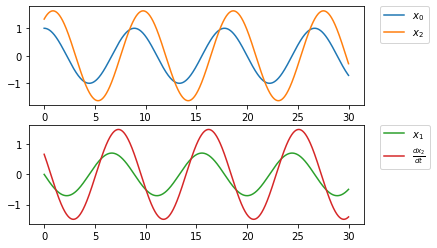

In [4]:
gm=GM()
omega = np.sqrt(gm.omega2)
nu = 2#gm.nu
time = np.arange(0, 30, 0.001 )
x0 = np.cos(omega*time)
x1 = -omega*np.sin(omega*time)
x2 = nu*(np.cos(omega*time)+omega*np.sin(omega*time))/(omega**2+1)
dx2 = nu*(-np.sin(omega*time)+omega**2*np.cos(omega*time))/(omega**2+1)
touch = gm.g_touch(x=x2, v=dx2)
dtouch_dx0 = gm.dg_dmu0(x=x2, v=dx2, dv_dmu0=nu)
dtouch_dx2 = gm.dg_dmu2(x=x2, v=dx2, dv_dmu2=-1)

plt.plot(figsize=(10,6))
plt.subplot(211)
plt.plot(time, x0, label=r"$x_0$", c='#1f77b4')
plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(time, x1, label=r"$x_1$", c='#2ca02c')
plt.plot(time, dx2, label=r"$\frac{dx_2}{dt}$", c='#d62728')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

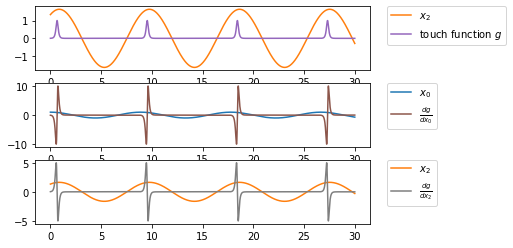

In [5]:
plt.subplot(311)
plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
plt.plot(time, touch, label=r"touch function $g$", c='#9467bd')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(312)
plt.plot(time, x0, label=r"$x_0$", c='#1f77b4')
plt.plot(time, dtouch_dx0, label=r"$\frac{dg}{dx_0}$", c='#8c564b')
#plt.plot(time, dtouch_dx2, label=r"$\frac{dg}{dx_2}$", c='#7f7f7f')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(313)
plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
plt.plot(time, dtouch_dx2, label=r"$\frac{dg}{dx_2}$", c='#7f7f7f')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



In [13]:

if __name__ == "__main__":
    dt = 0.0005
    n_steps = 20000
    gp = GP(dt=dt, omega2_GP=0.5, alpha=1)
    gm = GM(dt=0.005, eta=0.001, eta_d=0.1, eta_a=0.001, eta_nu=0.001, omega2_GM=0.5, nu=1)


In [14]:
    data_GP = []
    data_GM = []
    a = 0.
    for step in np.arange(n_steps):
        gp.update(0)
        a=gm.update(gp.s)
        data_GP.append([gp.x[2], gp.a, gp.s[0], gp.s[1] ])
        data_GM.append([ gm.mu[2], gm.nu, gm.PE_mu[0], gm.PE_mu[1], gm.PE_mu[2], gm.PE_s[0], gm.PE_s[1], gm.dmu[2] ])
    data_GP = np.vstack(data_GP)
    data_GM = np.vstack(data_GM)
    #platform = gp.platform_for_graph()

<ipython-input-1-d42694cbd062>:9: RuntimeWarning: overflow encountered in exp
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)
<ipython-input-1-d42694cbd062>:9: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)


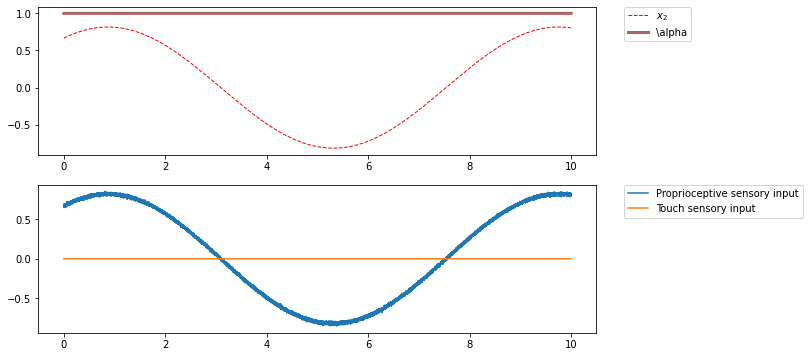

In [15]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:, 0], c="red", lw=1, ls="dashed", label=r"$x_2$")
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:, 1], c="#aa6666", lw=3, label=r"\alpha")
#plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
#plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:,2], label="Proprioceptive sensory input")
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:,3], label="Touch sensory input")
#plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
#plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


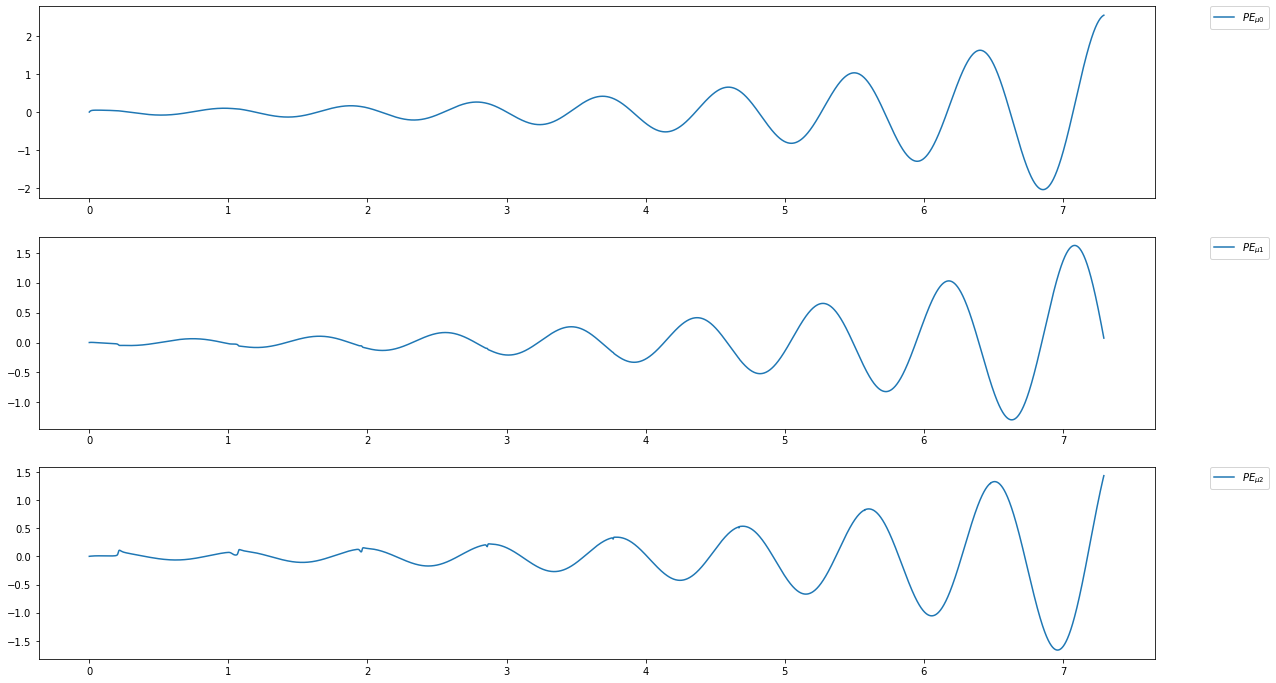

In [16]:
plt.figure(figsize=(20, 12))
plt.subplot(311)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 2], label=r"$PE_{\mu 0}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(312)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 3], label=r"$PE_{\mu 1}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(313)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 4], label=r"$PE_{\mu 2}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

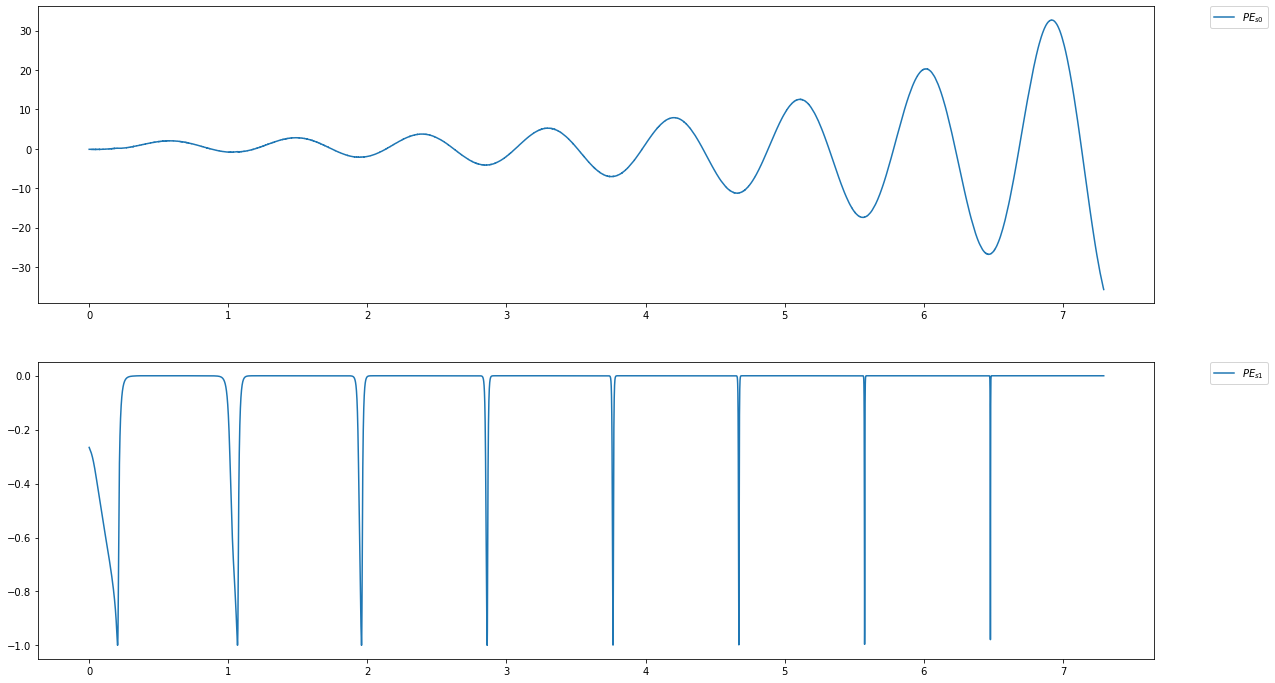

In [17]:
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 5], label=r"$PE_{s 0}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 6], label=r"$PE_{s 1}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


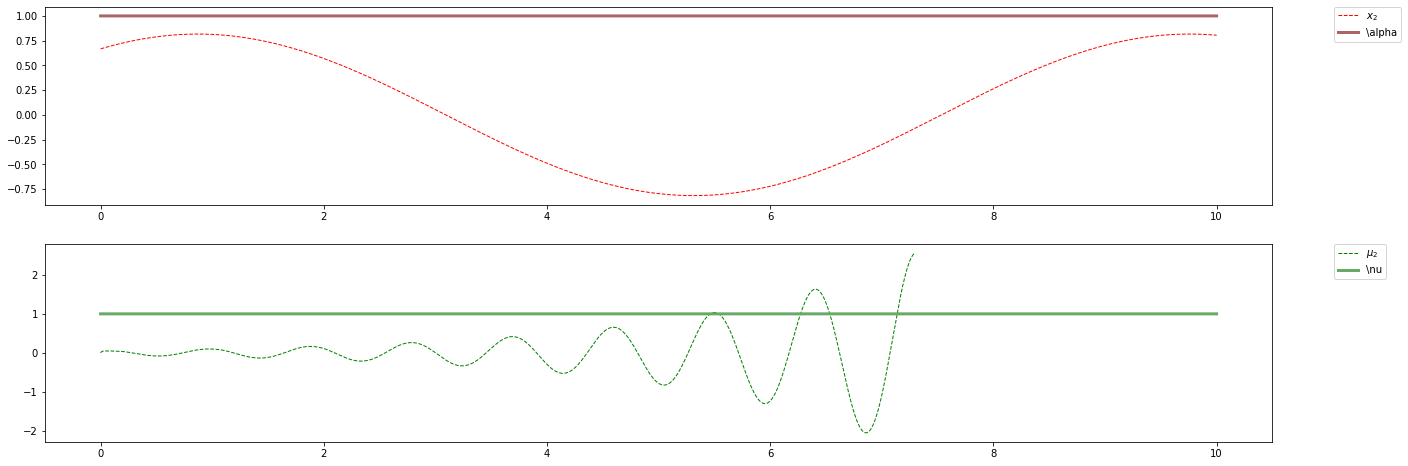

In [18]:
plt.figure(figsize=(22, 8))
plt.subplot(211)
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:, 0], c="red", lw=1, ls="dashed", label=r"$x_2$")
plt.plot(np.arange(0,n_steps*dt,dt), data_GP[:, 1], c="#aa6666", lw=3, label=r"\alpha")
#plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
#plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 2], c="green", lw=1, ls="dashed", label=r"$\mu_2$")
#plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 7], lw=1, ls="dashed", label=r"$\dot{\mu}_2$")
plt.plot(np.arange(0,n_steps*dt,dt), data_GM[:, 1], c="#66aa66", lw=3, label=r"\nu")
#plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()